<a href="https://colab.research.google.com/github/kocurvik/edu/blob/master/HUPV/notebooks/solutionscv08_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8. Cvičenie

Na dnešnom cvičení sa budeme hrať s jedným umelým prípadom. Budeme pracovať s šedotónovými obrázkami do ktorých pridáme vlnivý šum. Ten pridáme pomocou modifikácie obrazu vo Fourierovom spektre. To nám zabezpečí funkcia. Aby sme to upočítali na cvičení, tak budeme pridávať len horizontálny šum. S kódom sa môžete pohrať a skúsiť spojazdniť detekciu aj šikmého šumu.

Všetko budeme testovať na datasete, ktorý je podmnožinou datasetu ImageNet v zmenšenej forme na $91 \times 91$ a obrázky sú šedotónové.

V rámci tohto cvičenie si vytvoríme generátor dát, vlastnú cenovú funkciu a metriku na sledovanie, vlastnú vrstvu siete. 

## Disclaimer

Aby sme si demonštrovali použitie stridu, tak budeme používať konvolučné siete, ktorých architektúra je pre nášu úlohu zbytočne zložitá a nedosahuje ani až také dobré výsledky. Pre tento jednoduchý problém by stačila aj jednoduchá plne prepojená sieť. Z dnešného cvičenia si preto neberte to, ako tvoriť architektúru skôr ako implementovať veci z úloh.

In [ ]:
import os

import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

Najprv si stiahneme dataset a extrahujeme si ho. V datasete sú tri zložky train, val a mini_train. Mini_train máme na predbežné testovanie tréningu ako sme si ukazovali na druhom cvičení.

In [ ]:
!wget https://liveuniba-my.sharepoint.com/:u:/g/personal/kocur15_uniba_sk/EZPqtoQf7khPilfzukCwa8EByxieDwqLEbm0vzMuG2v0rg?download=1
!mv EZPqtoQf7khPilfzukCwa8EByxieDwqLEbm0vzMuG2v0rg?download=1 dataset.zip

--2021-11-19 22:10:20--  https://liveuniba-my.sharepoint.com/:u:/g/personal/kocur15_uniba_sk/EZPqtoQf7khPilfzukCwa8EByxieDwqLEbm0vzMuG2v0rg?download=1
Resolving liveuniba-my.sharepoint.com (liveuniba-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to liveuniba-my.sharepoint.com (liveuniba-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/kocur15_uniba_sk/Documents/dewave_dataset.zip [following]
--2021-11-19 22:10:20--  https://liveuniba-my.sharepoint.com/personal/kocur15_uniba_sk/Documents/dewave_dataset.zip
Reusing existing connection to liveuniba-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 45265608 (43M) [application/x-zip-compressed]
Saving to: ‘EZPqtoQf7khPilfzukCwa8EByxieDwqLEbm0vzMuG2v0rg?download=1’

EZPqtoQf7khPilfzukC 100%[===================>]  43.17M   153MB/s    in 0.3s    

2021-11-19 22:10:21 (153 MB/s) - ‘EZPqtoQf7khPilfzukCwa8EByxieDwqLEbm0vzMuG2v0rg?down

In [ ]:
!unzip dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/04146.jpg         
  inflating: train/04147.jpg         
 extracting: train/04148.jpg         
 extracting: train/04149.jpg         
 extracting: train/04150.jpg         
  inflating: train/04151.jpg         
 extracting: train/04152.jpg         
 extracting: train/04153.jpg         
  inflating: train/04154.jpg         
  inflating: train/04155.jpg         
 extracting: train/04156.jpg         
 extracting: train/04157.jpg         
  inflating: train/04158.jpg         
  inflating: train/04159.jpg         
  inflating: train/04160.jpg         
  inflating: train/04161.jpg         
  inflating: train/04162.jpg         
 extracting: train/04163.jpg         
 extracting: train/04164.jpg         
  inflating: train/04165.jpg         
  inflating: train/04166.jpg         
 extracting: train/04167.jpg         
  inflating: train/04168.jpg         
  inflating: train/04169.jpg         
 extracting: train/04170.jpg         

## Pravidelný šum

Pravidelný šum nám pridajú tieto funkcie. Ak ste mali predmet PSO, tak by ste mali vedieť na akom princípe tieto funkcie fungujú ak nie, tak pre účely dnešného cvičenia stačí ak budete tieto funkcie považovať za blackbox.

Funkcia predpokladá obrázky v tvare $91 \times 91$.

In [ ]:
def add_regular_noise(img, row, col, plot=False):
    # cols in range 1..48
    # rows in range 1..95
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    if plot:
        magnitude_spectrum = 20 * np.log(np.abs(fshift))
        plt.subplot(221), plt.imshow(img, cmap='gray')
        plt.title('Input Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(222), plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

    val = np.abs(f[0,0])/5

    fshift[row, col] = val
    fshift[90-row, 90-col] = val
    img_modified = np.real(np.fft.ifft2(np.fft.ifftshift(fshift)))

    if plot:
        magnitude_spectrum = 20 * np.log(np.abs(fshift))
        plt.subplot(223), plt.imshow(np.real(img_modified), cmap='gray')
        plt.title('Output Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(224), plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
        plt.show()

    return img_modified


def remove_regular_noise(img, row, col, plot=False):
      # cols in range 1..48
    # rows in range 1..95
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    if plot:
        magnitude_spectrum = 20 * np.log(np.abs(fshift))
        plt.subplot(221), plt.imshow(img, cmap='gray')
        plt.title('Input Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(222), plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

    fshift[row, col] = 0
    fshift[90-row, 90-col] = 0
    img_modified = np.real(np.fft.ifft2(np.fft.ifftshift(fshift)))

    if plot:
        magnitude_spectrum = 20 * np.log(np.abs(fshift))
        plt.subplot(223), plt.imshow(np.real(img_modified), cmap='gray')
        plt.title('Output Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(224), plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
        plt.show()

    return img_modified

Otestujeme na obrázkoch

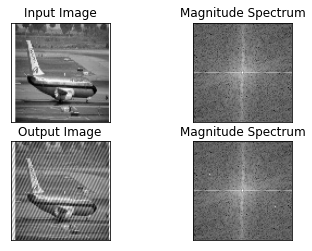

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log


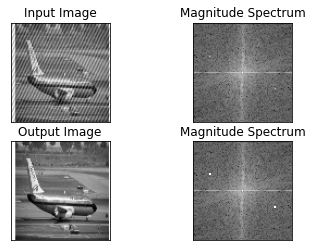

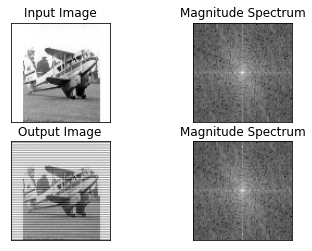

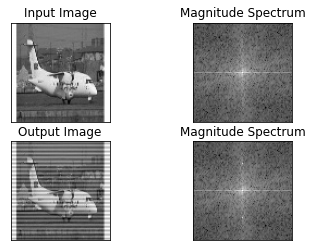

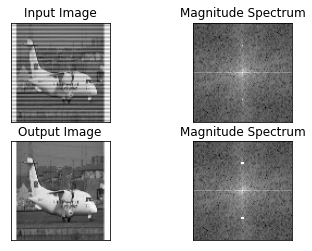

In [ ]:
img = cv2.cvtColor(cv2.imread('train/00652.jpg'),cv2.COLOR_BGR2GRAY)
img_modified = add_regular_noise(img, 30, 15, plot=True)
img_repaired = remove_regular_noise(img_modified, 30, 15, plot=True)

img = cv2.cvtColor(cv2.imread('train/00090.jpg'),cv2.COLOR_BGR2GRAY)
img_modified = add_regular_noise(img, 5, 45, plot=True)

img = cv2.cvtColor(cv2.imread('train/00450.jpg'),cv2.COLOR_BGR2GRAY)
img_modified = add_regular_noise(img, 20, 45, plot=True)
img_repaired = remove_regular_noise(img_modified, 20, 45, plot=True)


## Vlastný dataset

Pri trénovaní budeme chcieť vždy načítať náhodný obrázok z podmnožiny obrázkov a potom mu pridať náhodný šum.

Vlastný dataset si spravím tak, že implementujeme vlastnú triedu, ktorá bude dedičom `torch.utils.data.Dataset`. Na to aby dataset fungoval nám stačí implementovať metódy `__len__`, `__getitem__` a samozrejme konštruktor.

V konštruktore dostaneme ako vstupný argument zložku v ktorej sa nachádzajú obrázky. Následne ich načítame a uložíme ako jedno veľké np pole veľkosti $n \times 91 \times 91$ v rozashu hodnôt od 0 do 1.

Metóda `__len__` vráti veľkosť datasetu tj. počet prvkov trénovacej množiny. V našom prípade by sme sa nemuseli obmedziť na počet obrázkov, ale je to momentálne najjednoduchšie riešenie.

Metóda `__getitem__` má jeden argument a to index prvku, ktorý chceme. Tento index potrebujeme aby dataset mohol miešať jednotlivé elementy a zároveň aby sa dal jednoducho paralelizovať. V našom prípade teda načítame i-tý prvok z množiny obrázkov a potom doň pridáme náhodný šum. Obmedzíme sa len na horizontálny alebo vertikálny šum. Tj. ako druhý parameter vo funkcii `add_regular_noise` vždy použijete číslo 45. Na výstupe táto metóda vráti dict ktorý bude mať keys `img`, v ktorom bude obrázok ako $1 \times 91 \times 91$ torch tensor ako float32 a `row` v ktorom bude int hodnota ktorú ste použili pri pridávaní šumu. Túto hodnotu generujte náhodne v rozsahu 1 až 45. Túto metódu doimplemntujte.



In [ ]:
class RegularNoiseDataset(torch.utils.data.Dataset):
  def __init__(self, dir_path):
    files = os.listdir(dir_path)
    images = []
    for file in files:
        file = file.strip()
        images.append(cv2.cvtColor(cv2.imread(os.path.join(dir_path, file)), cv2.COLOR_BGR2GRAY))

    # pretypovanie je kľúčové inak vám sieť nebude fungovať!
    self.images = np.array(images) / 255
        

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img = self.images[idx]
    row = np.random.randint(1, 46)
    img = add_regular_noise(img, row, 45, plot=False).astype(np.float32)  
    
    sample = {'img': torch.from_numpy(img[np.newaxis, ...]), 'row': row}

    # sample = {'img': None, 'row': None}

    return sample

Tento testovací kód by mal úspešne zbehnúť a zobraziť zašumený obrázok.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log


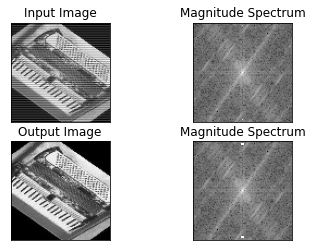

tensor(2)


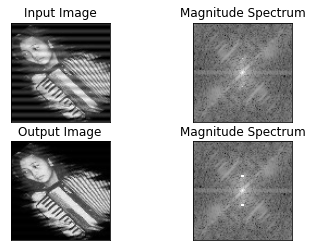

tensor(32)


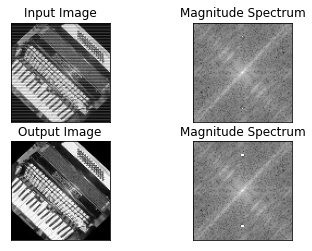

tensor(12)


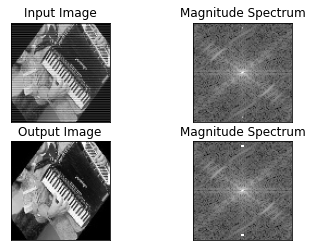

tensor(4)


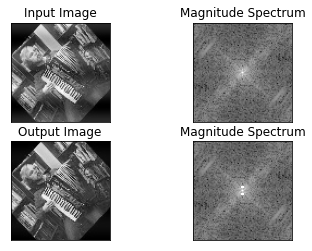

tensor(42)


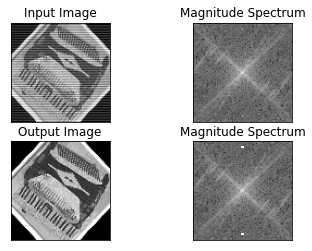

tensor(5)


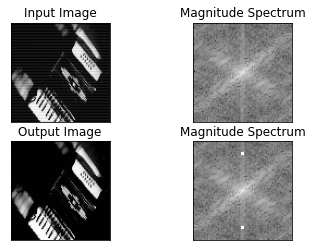

tensor(11)


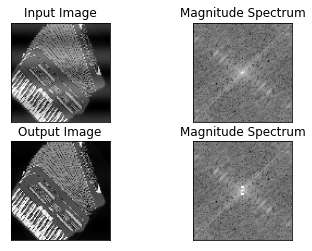

tensor(42)


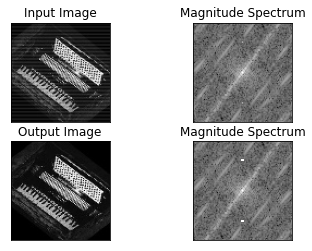

tensor(17)


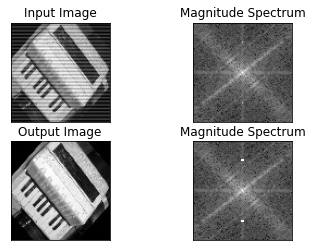

tensor(17)


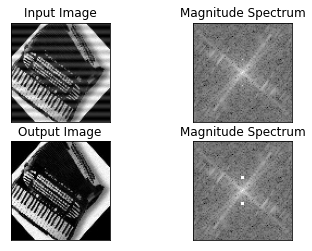

tensor(33)


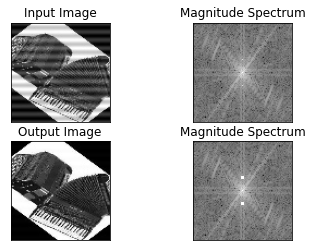

tensor(33)


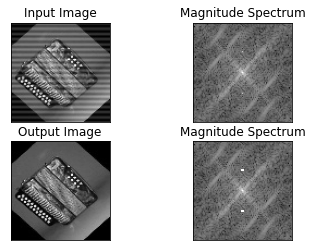

tensor(26)


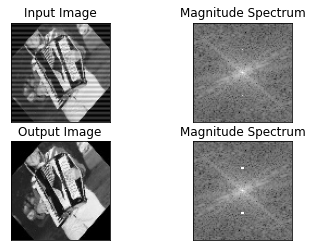

tensor(24)


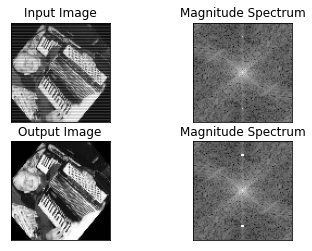

tensor(12)


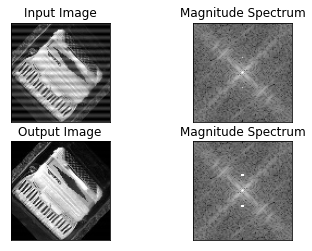

tensor(31)


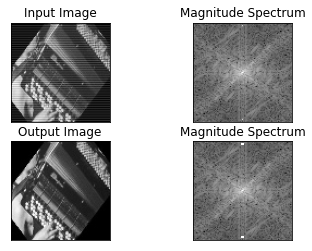

tensor(2)


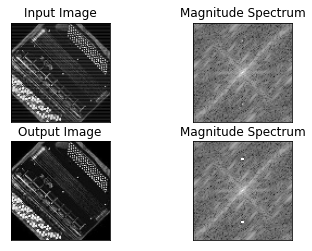

tensor(16)


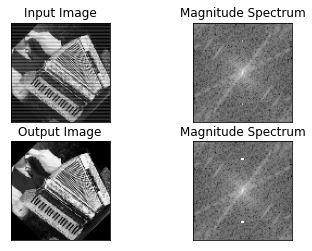

tensor(16)


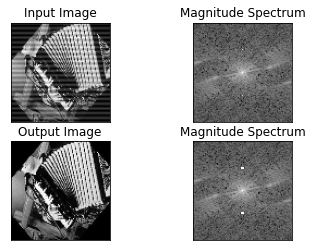

tensor(24)


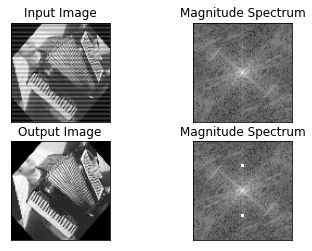

tensor(22)


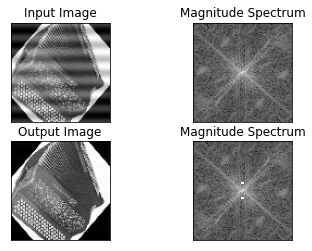

tensor(38)


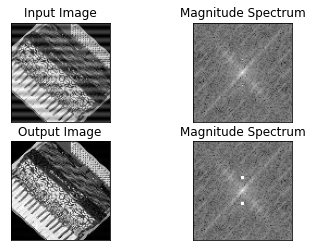

tensor(33)


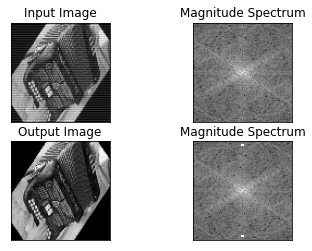

tensor(3)


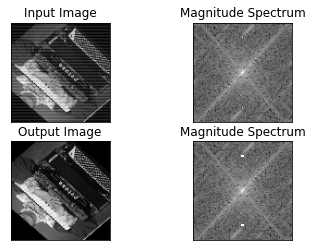

tensor(13)


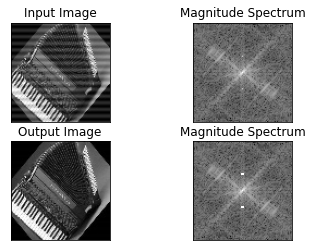

tensor(30)


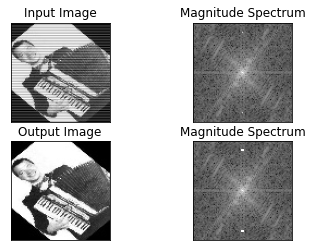

tensor(8)


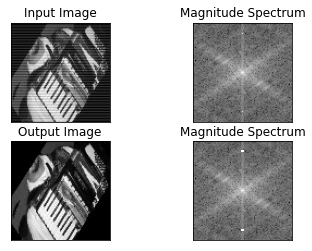

tensor(9)


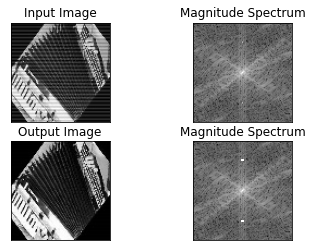

tensor(17)


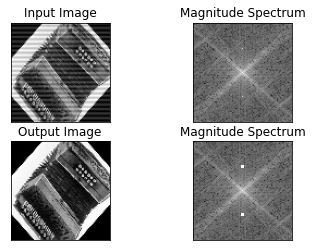

tensor(23)


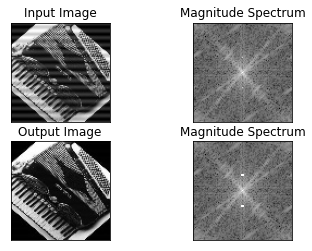

tensor(31)


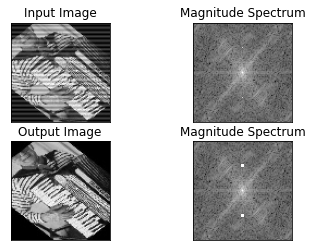

tensor(22)


In [ ]:
mini_dataset = RegularNoiseDataset('mini_train')
mini_loader = torch.utils.data.DataLoader(mini_dataset, batch_size=1)

for sample in mini_loader:
  img = sample['img'][0].numpy()
  row = sample['row'][0]
  
  img_denoised = remove_regular_noise(img[0], row, 45, plot=True)
  print(row)

## Jednoduchý klasifikačný model

Teraz si vytvoríme jednoduchý model a rovno si ho aj natrénujeme.

In [ ]:
from torch.nn import Sequential, Linear, ReLU, Softmax, Conv2d, MaxPool2d, AdaptiveAvgPool2d, Flatten

def build_model():
  model = Sequential(Conv2d(1, 64, 7, stride=3), ReLU(), 
                    Conv2d(64, 64, 5, stride=2), ReLU(),
                    Conv2d(64, 64, 5, stride=2), ReLU(),
                    Conv2d(64, 64, 3), ReLU(),
                    Conv2d(64, 128, 3), ReLU(),
                    Flatten(), 
                    Linear(128, 45))
  
  return model

Model si potom jednoducho natrénujeme.

*Pozn.:* Tu sa nám môže stať, že načítanie dát bude trvať dlhšie na CPU ako samotný výpočet siete. Preto ak by sme mali k dispozícii viac jadier, tak je na miesto použíť v konštruktore DataLoader argument `num_workers` väčší ako 1.

In [ ]:
trainset = RegularNoiseDataset('train')
valset = RegularNoiseDataset('val')

batch_size = 32

dataloader_train = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

In [ ]:
model = build_model().cuda()
print(model)

ce_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for e in range(2):
  model.train()
  for i, samples in enumerate(dataloader_train):  
    imgs = samples['img'].cuda()
    rows = samples['row'].cuda()  
    optimizer.zero_grad()

    out = model(imgs)
    loss = ce_loss(out, rows - 1)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
      print("Loss at epoch: {} step {}: {}".format(e, i, loss.item()))

  model.eval()
  with torch.no_grad():
    val_losses = []
    correct = 0
    total = 0
    for i, samples in enumerate(dataloader_val):  
      imgs = samples['img'].cuda()
      rows = samples['row'].cuda()  

      out = model(imgs)
      loss = ce_loss(out, rows - 1)
      acc = torch.sum(torch.argmax(out, dim=-1) == rows - 1)
      correct += acc.item()
      val_losses.append(loss.item())
      total += len(rows)

    print("Val loss at epoch {}: {}".format(e, np.mean(val_losses)))
    print("Val acc at epoch {}: {}".format(e, correct / total))

Sequential(
  (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(3, 3))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2))
  (3): ReLU()
  (4): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2))
  (5): ReLU()
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU()
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=128, out_features=45, bias=True)
)
Loss at epoch: 0 step 0: 3.805954933166504
Loss at epoch: 0 step 100: 2.089357376098633
Loss at epoch: 0 step 200: 0.3378848433494568
Val loss at epoch 0: 0.21959732133481238
Val acc at epoch 0: 0.9274647887323944
Loss at epoch: 1 step 0: 0.5592457056045532
Loss at epoch: 1 step 100: 0.018734270706772804
Loss at epoch: 1 step 200: 0.05137151479721069
Val loss at epoch 1: 0.12284044530501383
Val acc at epoch 1: 0.9654929577464789


Model si otestujeme

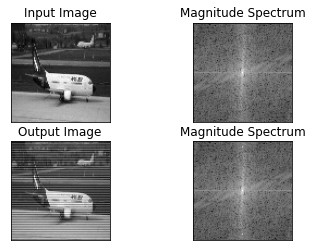

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log


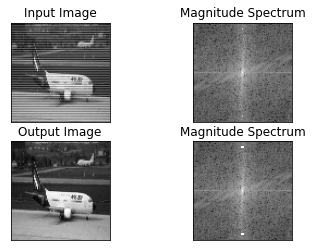

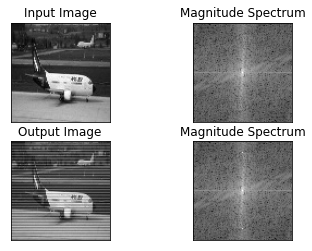

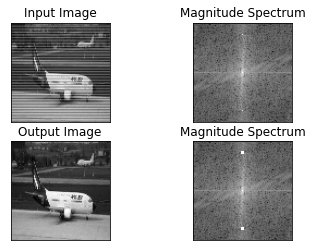

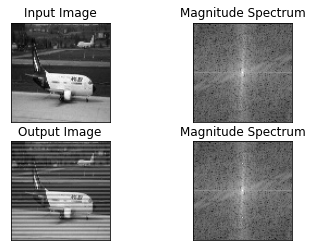

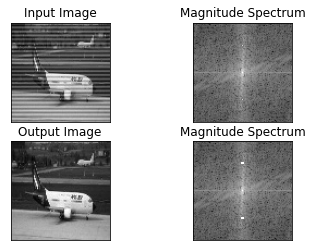

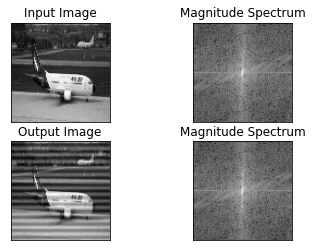

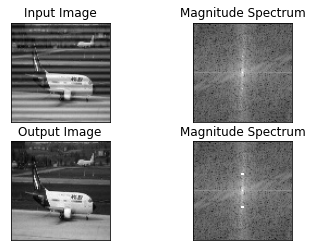

In [ ]:
for img_name in ['val/00091.jpg']:
  img = cv2.cvtColor(cv2.imread('val/00091.jpg'),cv2.COLOR_BGR2GRAY)

  for gt_rows in [5, 10, 20, 30]:
    img_modified = add_regular_noise(img, gt_rows, 45, plot=True)

    input = torch.from_numpy(img_modified[np.newaxis, np.newaxis, ...].astype(np.float32)).cuda()
    out = model(input)
    row = torch.argmax(out[0]) + 1
    img_repaired = remove_regular_noise(img_modified, row, 45, plot=True)

## Vlastná vrstva

Teraz si vyrobíme vlastnú vrstvu. Keďže v našom umelom prípade sa vždy snažíme v podstate identifikovať frekvenciu pridaných vĺn, tak by sme radi identifikovali tieto frekvencie. Na to použijeme konvolúciu s jadrom o rozmeroch $91 \times 1$. Týchto jadier budeme mať viacero a každé jadro bude predstavovať nejakú frekvenciu. Práve frekvencia a fázový posun budú naučiteľné parametre. Hodnoty jadra $w_0, w_1, ... w_{90}$ pre jednú frekvenciu $\omega$ a fázu $\phi$ budú:

$$ w_k = \mbox{sin}\left( \frac{2\pi \cdot k}{90} \omega + \phi \right)$$.

Pred aplikáciou ešte z obrazu odčítame 0.5 aby to dávalo zmysel. Toto jadro aplikujeme bez paddingu a tak nám akoby eliminuje jednu dimenziu (rád) tenzoru. Po aplikácii sa ešte spočíta priemer za posledné dve dimenzie. Takto špecifické jadro samozrejme nebude možné použiť inde ako na začiatku našej siete.

Praktickú implementáciu budeme realizovať podľa [dokmentácie](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=module#torch.nn.Module). 

Potrebujeme teda triedu, ktorá dedí od `torch.nn.Module`. V konštruktore musíme zavolať aj konštruktor predka. V konštruktore si zapamätáme koľko filtrov chceme použiť. V tejto metóde je nutné tiež nainicializovať trénovateľné premenné (vektor frekvencií a vektor fáz.) triedy `torch.nn.parameter.Parameter`. Pri použití tejto triedy sa nám tieto parametre automaticky pridajú k trénovateľným premenným modulu. Dôležité je premenné správne nainicializovať. Na to použijeme rovnomernú distribúciu pomocou `torch.rand` ako prvý arugment konštruktora `Variable`. Frekvencie inicializujeme od -100 do 100 a fázu od $-\frac{\pi}{2}$ do $\frac{\pi}{2}$. Druhý argument je `requires_grad=True`.

Potom potrebujeme ešte metódu `forward`. Ako jediný argument má vstupný tenzor. Vnútornú logiku musíme skladať zo základných torch funkcií. Najprv si vygenerujeme kernel pomocou hodnôt $\frac{2\pi \cdot k}{90}$. Na generovanie k sa vám zíde sa vám napr. `torch.linspace`. Tu je dôležité tensor k poslať na device rovnaký ako vstupný argument funcie forward pomocou metódy napr.: `k.to(x.device)`. Alternatívne je možné k deklarovať v konštruktore pomocou metódy `self.register_buffer` v takom prípade ho nebude treba vždy generovať nanovo vždy sa nainicializuje na rovnaký device ako celý model. Vektor k potom prenásobíme s frekvenciami, tak aby nám sedeli rozmery (využijeme maticové násobenie, tak že vektorom pridáme singleton dimenzie). Potom k nim pričítame fázy a aplikujeme sínus. Kernel generujeme tak aby sme ho vedeli použíť pomocou [torch.nn.functional.conv2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html?highlight=torch%20functional%20conv2d#torch.nn.functional.conv2d).

 Na vstupný tensor od ktorého ešte odrátame jednu polovicu použijeme `torch.nn.functional.conv2d` s našim kernelom. Následne vypriemerujeme hodnoty cez posledné dve dimenzie pomocou `torch.mean`.

In [ ]:
class WaveLayer(torch.nn.Module):
  def __init__(self, num_weights):
    super(WaveLayer, self).__init__()
    self.phases = torch.nn.parameter.Parameter(torch.pi * torch.rand(num_weights) - torch.pi/2, requires_grad=True)
    self.weights = torch.nn.parameter.Parameter(200 * torch.rand(num_weights) - 100, requires_grad=True)
    self.register_buffer('k', torch.linspace(0, 2 * torch.pi, 91))
    
  def forward(self, x):
    # ak sme nepoužili save buffer tak treba urobiť
    # k =  torch.linspace(0, 2 * torch.pi, 91).to(x.device)

    kernel = torch.sin(self.weights[:, None, None, None] * self.k[None, None, : , None] + self.phases[:, None, None, None])
    x = torch.nn.functional.conv2d(x, kernel, padding=0)
    x = torch.mean(x, dim=-1)
    x = torch.mean(x, dim=-1)
    return x
    

Vrstvu si otestujeme.

In [ ]:
wave_layer = WaveLayer(200)

rand_input = torch.randn(1, 1, 91, 91)

output = wave_layer(rand_input)

# výstup by mal byť [1, 200]
print(output.size())

torch.Size([1, 200])


Môžeme si vygenerovať aj jednoduchý model a skúsiť natrénovať.

In [ ]:
from torch.nn import Sequential, Linear, ReLU

def build_custom_model():
  model = Sequential(WaveLayer(128),
                     Linear(128, 64), ReLU(),
                     Linear(64, 45))
    
  return model

Overíme si či model má naozaj parametre ktoré chceme trénovať $\omega$ a $\phi$.

In [ ]:
print([p.size() for p  in build_custom_model().parameters()])

[torch.Size([128]), torch.Size([128]), torch.Size([64, 128]), torch.Size([64]), torch.Size([45, 64]), torch.Size([45])]


In [ ]:
custom_model = build_custom_model().cuda()
print(custom_model)

ce_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_model.parameters(), lr=1e-3)

for e in range(3):
  model.train()
  for i, samples in enumerate(dataloader_train):  
    imgs = samples['img'].cuda()
    rows = samples['row'].cuda()
    optimizer.zero_grad()

    out = custom_model(imgs)
    loss = ce_loss(out, rows - 1)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
      print("Loss at epoch: {} step {}: {}".format(e, i, loss.item()))

  model.eval()
  with torch.no_grad():
    val_losses = []
    correct = 0
    total = 0
    for i, samples in enumerate(dataloader_val):  
      imgs = samples['img'].cuda()
      rows = samples['row'].cuda()  

      out = custom_model(imgs)
      loss = ce_loss(out, rows - 1)
      acc = torch.sum(torch.argmax(out, dim=-1) == rows - 1)
      correct += acc.item()
      val_losses.append(loss.item())
      total += len(rows)

    print("Val loss at epoch {}: {}".format(e, np.mean(val_losses)))
    print("Val acc at epoch {}: {}".format(e, correct / total))

Sequential(
  (0): WaveLayer()
  (1): Linear(in_features=128, out_features=64, bias=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=45, bias=True)
)
Loss at epoch: 0 step 0: 3.956728935241699
Loss at epoch: 0 step 100: 1.3230253458023071
Loss at epoch: 0 step 200: 0.3024255335330963
Val loss at epoch 0: 0.24877432468864652
Val acc at epoch 0: 0.9830985915492958
Loss at epoch: 1 step 0: 0.26167014241218567
Loss at epoch: 1 step 100: 0.13346928358078003
Loss at epoch: 1 step 200: 0.030045153573155403
Val loss at epoch 1: 0.11736772461897797
Val acc at epoch 1: 0.9823943661971831
Loss at epoch: 2 step 0: 0.17631793022155762
Loss at epoch: 2 step 100: 0.008668500930070877
Loss at epoch: 2 step 200: 0.10092479735612869
Val loss at epoch 2: 0.0781495968811214
Val acc at epoch 2: 0.9880281690140845


Model taktiež otestujeme.

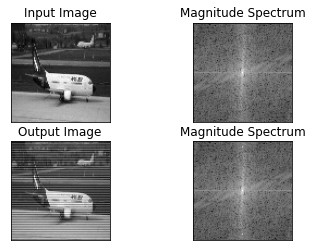

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log


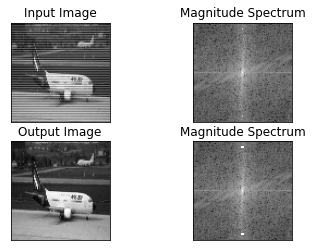

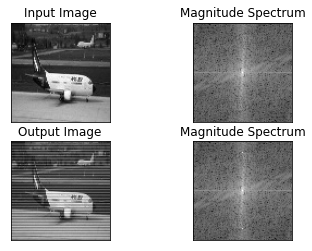

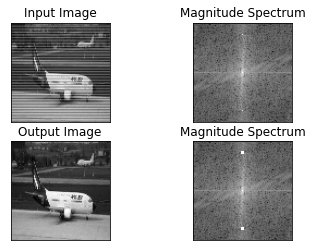

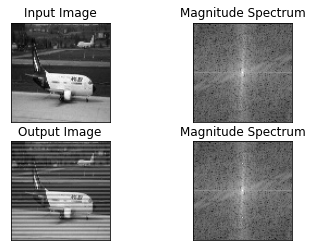

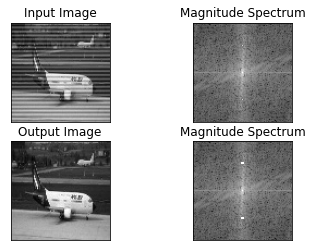

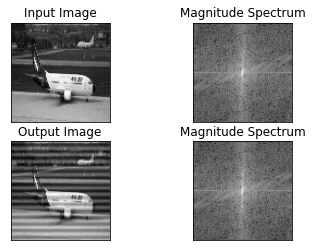

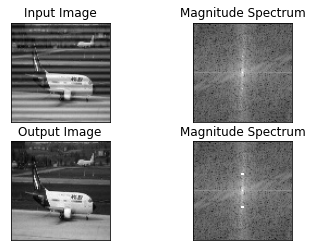

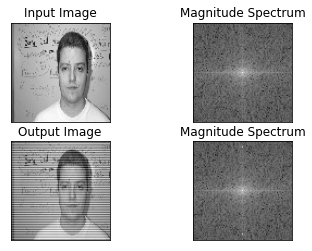

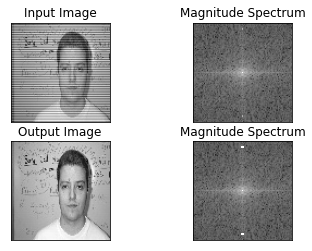

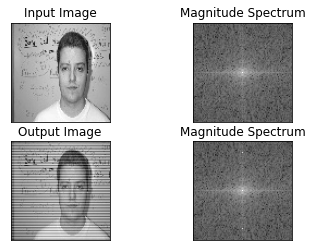

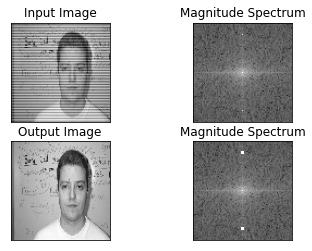

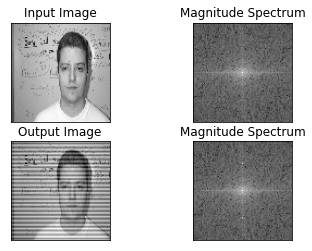

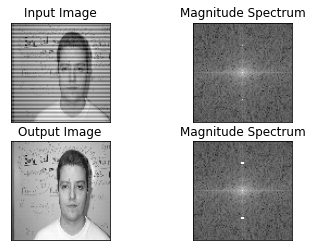

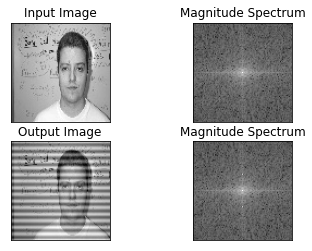

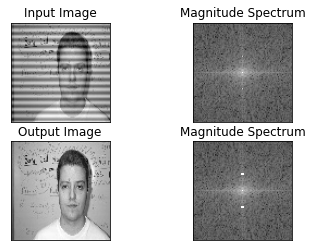

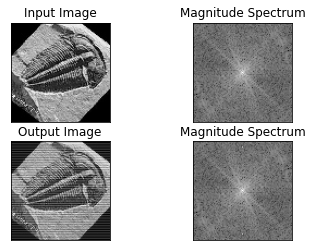

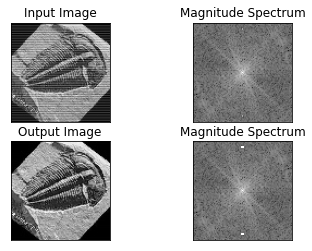

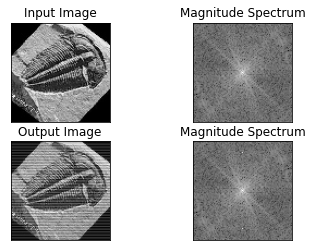

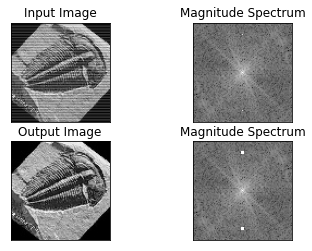

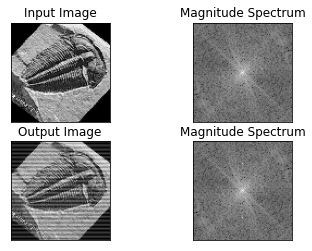

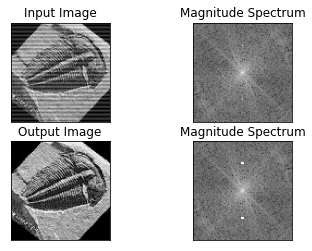

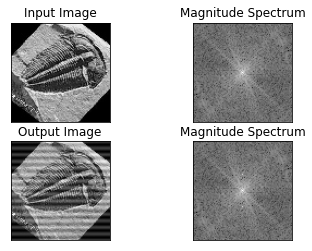

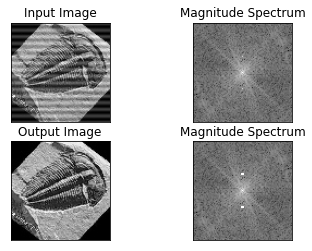

In [ ]:
for img_name in ['val/00091.jpg', 'val/00572.jpg', 'val/01320.jpg']:
  img = cv2.cvtColor(cv2.imread(img_name),cv2.COLOR_BGR2GRAY)

  for gt_rows in [5, 10, 20, 30]:
    img_modified = add_regular_noise(img, gt_rows, 45, plot=True)

    input = torch.from_numpy(img_modified[np.newaxis, np.newaxis, ...].astype(np.float32)).cuda()
    out = custom_model(input)
    row = torch.argmax(out[0]) + 1
    img_repaired = remove_regular_noise(img_modified, row, 45, plot=True)

## Bonusové úlohy - Regresia

Doteraz sme úlohu riešili ako klasifikáciu. Skúste implementovať sieť ktorá bude mať na výsupe len jednu hodnotu a tá sa potom zaukrúhli na najbližší int v rozmedzí od 1 do 45. Na tréning skúste použiť najrpv MSE (a.k.a L2) Loss. 

### Vlastná cenová funkcia

MSE nemusí byť úplne najlepšia cenová funkcia aj keď sa bežne využíva. My si definujeme tzv. smooth L1 cenovú funkciu. Tá je podoná L1 norme chyby, až na to, že v okolí nuly je hladká. Definícia je nasledovná:

$$ smooth_{L1}(x) = \begin{cases} \frac{1}{2} x^2 & \mbox{ak}~|x| \le 1 \\|x| - \frac{1}{2} & \mbox{inak} \end{cases}$$

Postupovať je jednoduchý. Je potrebné si vyrobiť funkciu ktorá ma na vstupe y_pred a y_true. Vo funkcii použite iba `torch.*`, alebo `torch.nn.functional` funkcie. Zíde sa vám napr. `torch.mean`, `torch.where` atď.

### Dotačné acc

Ak si budete vypisovať presnosť počas tréningu, tak by bolo lepšie vypísať si aj napr presnosť s toleranciou +/- 3, aby sme vedeli či sa blížime k lepšiemu výsledku. Skúste si napísať takúto funkciu aby reportovala počas tréningu tieto výsledky.
